# Comparison of NSF and PRISMO on SlideSeq Data from NSF Paper

## NSF

In [37]:
# # requires the nsf-paper conda environment to be activated

# import pickle as pkl

# import numpy as np
# import spatial_factorization as sf
# from data_loader import load_nsf_slideseq
# from tensorflow.data import Dataset

# adata = load_nsf_slideseq()

# # prepare data for SpatialFactorization model
# data = {
#     "X": adata.obsm["spatial"].copy().astype("float32"),
#     "Y": adata.layers["counts"].toarray().astype("float32"),
#     "sz" : np.ones((adata.n_obs, 1), dtype="float32"),
#     "idx" : np.arange(adata.n_obs)
#     }
# data_tf = Dataset.from_tensor_slices(data)
# data_tf = data_tf.batch(adata.n_obs)
# inducing_locations = sf.misc.kmeans_inducing_pts(data["X"], 1000)

# # setup and train SpatialFactorization model
# nsf_model = sf.SpatialFactorization(
#     J=adata.n_vars,
#     L=5,
#     Z=inducing_locations,
#     lik="poi",
#     nonneg=True,
# )
# nsf_model.init_loadings(data["Y"])
# trainer = sf.ModelTrainer(nsf_model)
# trainer.train_model(data_tf, adata.n_obs, None)

# # obtain inferred latent variables
# z_nsf = np.exp(nsf_model.sample_latent_GP_funcs(data["X"], S=100).numpy().mean(axis=0).T)
# w_nsf = nsf_model.get_loadings()

# pkl.dump({"z" : z_nsf, "w" : w_nsf}, open("lvs/nsf.pkl", "wb"))

## PRISMO

In [2]:
from data_loader import load_nsf_slideseq
from prismo import PRISMO, DataOptions, ModelOptions, TrainingOptions, SmoothOptions

adata = load_nsf_slideseq()

for seed in range(1):
    prismo_model = PRISMO(
        adata,
        DataOptions(
            covariates_obsm_key="spatial",
            plot_data_overview=False
        ),
        ModelOptions(
            n_factors=10,
            weight_prior="Horseshoe",
            factor_prior="GP",
            likelihoods="GammaPoisson",
            nonnegative_weights=True,
            nonnegative_factors=True
        ),
        TrainingOptions(
            device="cuda:0",
            early_stopper_patience=100,
            batch_size=10000,
            max_epochs=1000,
            lr=5e-3,
            print_every=50,
            save_path=f"models_hs/prismo_{seed}",
            seed=seed
        ),
        SmoothOptions(
            n_inducing=1000,
            kernel="Matern"
        )
    )

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
INFO:prismo._core.prismo:Epoch:       0 | Time:       2.64s | Loss:   11946.38


## Comparison

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofax as mofa
from prismo import PRISMO
from prismo.tl import match
from plotnine import *
from data_loader import load_nsf_slideseq
import os
import h5py
import pickle as pkl

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [39]:
view_names = {
    "rna" : "mRNA"
}

In [40]:
data = load_nsf_slideseq()

In [41]:
z_nsf, w_nsf = pkl.load(open("lvs/nsf.pkl", "rb")).values()

z_nsf = pd.DataFrame(
    z_nsf,
    columns=[f"Factor {i}" for i in range(z_nsf.shape[1])],
    index=data.obs_names
)

w_nsf_dict = {}
for view in view_names.keys():
    w_nsf_dict[view_names[view]] = pd.DataFrame(
        w_nsf,
        columns=[f"Factor {i}" for i in range(w_nsf.shape[1])],
        index=data.var_names
    )
w_nsf = w_nsf_dict

z_prismo = {}
w_prismo = {}
prismo_model = {}
for seed in range(1):
    prismo_model[seed] = PRISMO.load(f"models_hs_main/prismo_{seed}.h5")
    z_prismo[seed] = prismo_model[seed].get_factors()['group_1']
    w_prismo[seed] = {}
    for view in view_names.keys():
        w_prismo[seed][view_names[view]] = prismo_model[seed].get_weights()["view_1"].T

### Factor matching based on correlation

In [42]:
for seed in range(1):
    z_nsf_inds, z_prismo_inds, z_signs = match(z_nsf, z_prismo[seed], dim=-1)

    z_prismo[seed] = z_prismo[seed].iloc[:, z_prismo_inds]
    z_prismo[seed] = z_prismo[seed] * z_signs.reshape(1, -1)
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

    for view in w_prismo[seed].keys():
        w_prismo[seed][view] = w_prismo[seed][view].iloc[:, z_prismo_inds]
        w_prismo[seed][view] = w_prismo[seed][view] * z_signs.reshape(1, -1)
        w_prismo[seed][view].columns = [f"Factor {i+1}" for i in range(w_prismo[seed][view].shape[1])]

### Correlation plots

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2.4 x 2 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/correlations.pdf
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 10 rows containing missing values.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 10 rows con

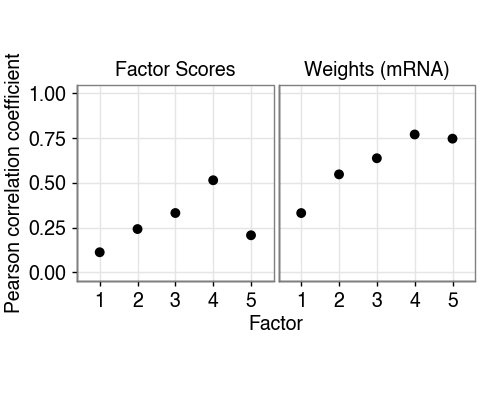

In [43]:
df = []
for seed in range(1):
    corr = []
    for i in range(z_prismo[seed].shape[1]):
        corr.append(pearsonr(z_prismo[seed].iloc[:, i], z_nsf.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(z_prismo[seed].shape[1])]
    df[-1]["lv"] = "Factor Scores"

    for view in w_prismo[seed].keys():
        corr = []
        for i in range(w_prismo[seed][view].shape[1]):
            corr.append(pearsonr(w_prismo[seed][view].iloc[:, i], w_nsf[view].iloc[:, i])[0])
        df.append(pd.DataFrame(corr, columns=[f"corr"]))
        df[-1]["seed"] = seed
        df[-1]["factor"] = [f"{i+1}" for i in range(w_prismo[seed][view].shape[1])]
        df[-1]["lv"] = f"Weights ({view})"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(10)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0, a_max=10)
df["max"] = np.clip(df["max"], a_min=0, a_max=10)

plot = (
    ggplot(df, aes(x="factor", y="mean"))
    + geom_point(size=1.)
    + geom_line()
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=5)
    + theme(
        figure_size=(2.4, 2),
    )
    + labs(x="Factor", y="Pearson correlation coefficient")
    + ylim(0., 1.)
)
plot.save("plots/correlations.pdf")
plot.show()

### Weights scatter plots

In [44]:
def plot_weights(view, factor, w_prismo, w_nsf):
    df = pd.DataFrame(w_prismo[view][factor])
    df.columns = ["weight_prismo"]
    df["weight_nsf"] = w_nsf[view][factor]
    df["weight_prismo_abs"] = df["weight_prismo"].abs()
    df["weight_nsf_abs"] = df["weight_nsf"].abs()

    plot = (
        ggplot(df, aes(x="weight_prismo", y="weight_nsf"))
        + geom_point(size=.1)
        + labs(x="PRISMO", y="NSF", title=f"Weights {factor}")
        + theme(figure_size=(1.5, 1.5), plot_title=element_text(ha='left'))
        + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
        + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    )
    return plot

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor1_weights.pdf


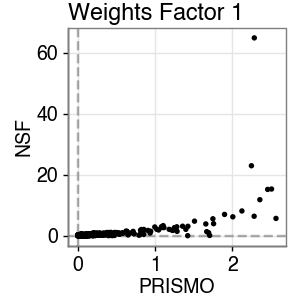

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor2_weights.pdf


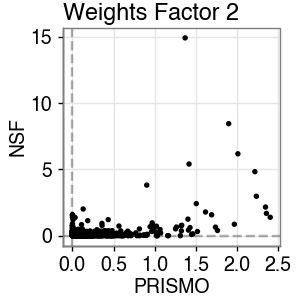

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor3_weights.pdf


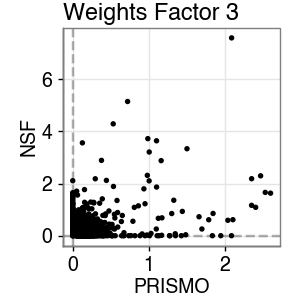

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor4_weights.pdf


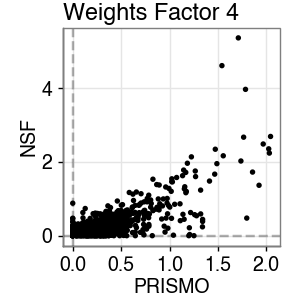

In [45]:
for i in range(1, 5):
    plot = plot_weights("mRNA", f"Factor {i}", w_prismo[0], w_nsf)
    plot.save(f"plots/factor{i}_weights.pdf")
    plot.show()

### Factor scatter plots

In [46]:
def plot_factors(factor, z_prismo, z_nsf):
    df = pd.DataFrame(z_prismo.loc[:, factor])
    df.columns = ["factor_prismo"]
    df["factor_nsf"] = z_nsf.loc[:, factor]
    df["factor_prismo_abs"] = df["factor_prismo"].abs()
    df["factor_nsf_abs"] = df["factor_nsf"].abs()

    plot = (
        ggplot(df, aes(x="factor_prismo", y="factor_nsf"))
        + geom_point(size=.01)
        + labs(x="PRISMO", y="nsf", title=f"Factor Scores {factor}")
        + theme(figure_size=(1.5, 1.5))
        + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
        + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    )
    return plot

In [47]:
# for i in range(1, 5):
#     plot = plot_factors(f"Factor {i}", z_prismo[0], z_nsf)
#     plot.save(f"plots/factor{i}_factors.pdf")
#     plot.show()

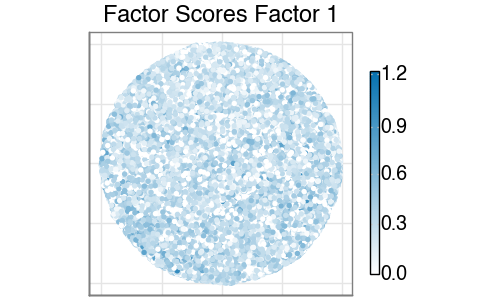

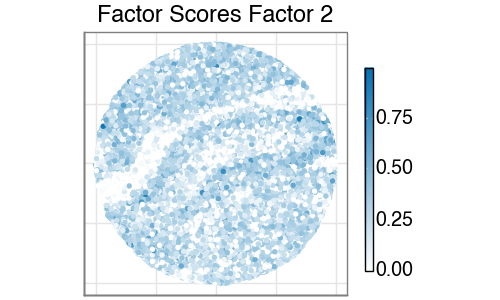

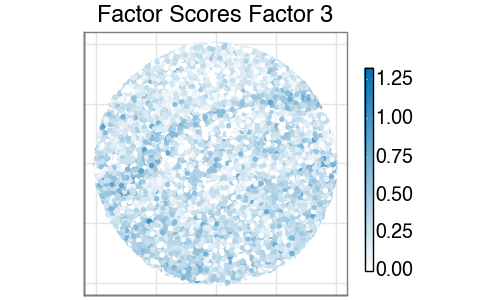

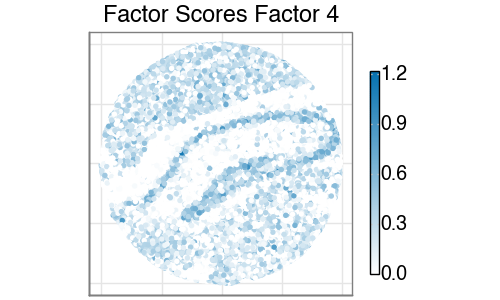

In [48]:
covariates_df = pd.DataFrame(prismo_model[0].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_prismo[0], columns=[f"Factor {i+1}" for i in range(z_prismo[0].shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]

for factor in range(1, 5):
    plot = (ggplot(df, aes(x="x", y="y", color=f"Factor {factor}"))
        + geom_point(size=0.1)
        + theme(figure_size=(2.5, 1.5), axis_text_x=element_blank(), axis_text_y=element_blank(), axis_ticks_major_x=element_blank(), axis_ticks_major_y=element_blank(), legend_key_width=3.)
        + labs(x="", y="", color="", title=f"Factor Scores Factor {factor}")
        + coord_fixed(ratio=1)
        + scale_color_gradient(low="white", high="#0571b0")
    )

    fig = plot.draw()
    points = fig.axes[0].collections[0]
    points.set_rasterized(True)
    fig.savefig(f"plots/prismo_factor_{factor}.pdf")
    plot.show()

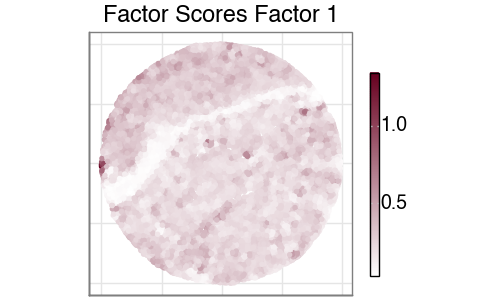

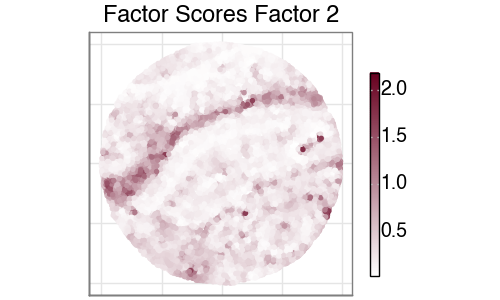

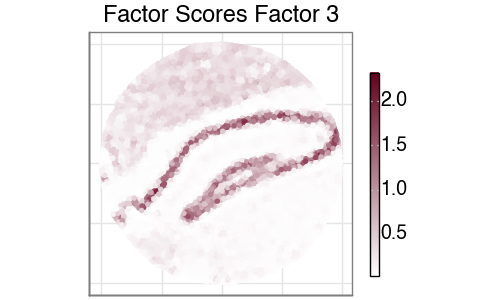

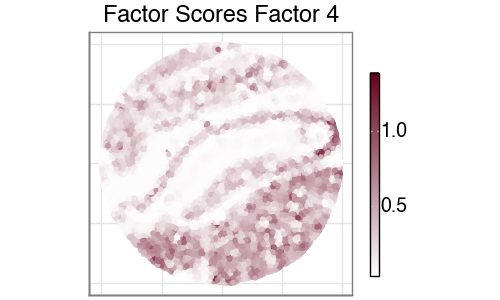

In [21]:
covariates_df = pd.DataFrame(prismo_model[0].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_nsf, columns=[f"Factor {i+1}" for i in range(z_prismo[0].shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]

for factor in range(1, 5):
    plot = (ggplot(df, aes(x="x", y="y", color=f"Factor {factor}"))
        + geom_point(size=0.1)
        + theme(figure_size=(2.5, 1.5), axis_text_x=element_blank(), axis_text_y=element_blank(), axis_ticks_major_x=element_blank(), axis_ticks_major_y=element_blank(), legend_key_width=3.)
        + labs(x="", y="", color="", title=f"Factor Scores Factor {factor}")
        + coord_fixed(ratio=1)
        + scale_color_gradient(low="white", high="#67001f")
    )

    fig = plot.draw()
    points = fig.axes[0].collections[0]
    points.set_rasterized(True)
    fig.savefig(f"plots/nsf_factor_{factor}.pdf")
    plot.show()